In [80]:
import numpy as np

from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

x = np.linspace(0, 10, 500)
y = np.sin(x)

source = ColumnDataSource(data=dict(x=x, y=y))

plot = figure(y_range=(-10, 10), width=400, height=400)

plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

amp_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")
freq_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Frequency")
phase_slider = Slider(start=0, end=6.4, value=0, step=.1, title="Phase")
offset_slider = Slider(start=-5, end=5, value=0, step=.1, title="Offset")

callback = CustomJS(args=dict(source=source, amp=amp_slider, freq=freq_slider, phase=phase_slider, offset=offset_slider),
                    code="""
    const data = source.data;
    const A = amp.value;
    const k = freq.value;
    const phi = phase.value;
    const B = offset.value;
    const x = data['x']
    const y = data['y']
    for (let i = 0; i < x.length; i++) {
        y[i] = B + A*Math.sin(k*x[i]+phi);
    }
    source.change.emit();
""")

amp_slider.js_on_change('value', callback)
freq_slider.js_on_change('value', callback)
phase_slider.js_on_change('value', callback)
offset_slider.js_on_change('value', callback)

layout = row(
    plot,
    column(amp_slider, freq_slider, phase_slider, offset_slider),
)

show(layout)

In [75]:
import pandas as pd
import numpy as np
import matplotlib as mpl # optional (here)
import matplotlib.pyplot as plt
import seaborn as sns # Optional, will only affect the color of bars and the grid
import ipywidgets as wid
from ipywidgets import widgets, interactive

In [2]:
from io import StringIO

testdata=StringIO("""Year,Sex,Area,Count
2015,W,Dhaka,6
2015,M,Dhaka,3
2015,W,Khulna,1
2015,M,Khulna,8
2014,M,Dhaka,13
2014,W,Dhaka,20
2014,M,Khulna,9
2014,W,Khulna,6
2013,W,Dhaka,11
2013,M,Dhaka,2
2013,W,Khulna,8
2013,M,Khulna,5
2012,M,Dhaka,12
2012,W,Dhaka,4
2012,W,Khulna,7
2012,M,Khulna,1
    """)

df = pd.read_csv(testdata, sep=",")

In [78]:
def multi_checkbox_widget(options_dict):
    """ Widget with a search field and lots of checkboxes """
    search_widget = wid.Text()
    output_widget = wid.Output()
    options = [x for x in options_dict.values()]
    options_layout = wid.Layout(
        overflow='auto',
        border='1px solid black',
        width='300px',
        height='300px',
        flex_flow='column',
        display='flex'
    )
    
    #selected_widget = wid.Box(children=[options[0]])
    options_widget = wid.VBox(options, layout=options_layout)
    #left_widget = wid.VBox(search_widget, selected_widget)
    multi_select = wid.VBox([search_widget, options_widget])

    @output_widget.capture()
    def on_checkbox_change(change):
        
        selected_recipe = change["owner"].description
        #print(options_widget.children)
        #selected_item = wid.Button(description = change["new"])
        #selected_widget.children = [] #selected_widget.children + [selected_item]
        options_widget.children = sorted([x for x in options_widget.children], key = lambda x: x.value, reverse = True)
        
    for checkbox in options:
        checkbox.observe(on_checkbox_change, names="value")

    # Wire the search field to the checkboxes
    @output_widget.capture()
    def on_text_change(change):
        search_input = change['new']
        if search_input == '':
            # Reset search field
            new_options = sorted(options, key = lambda x: x.value, reverse = True)
        else:
            # Filter by search field using difflib.
            #close_matches = difflib.get_close_matches(search_input, list(options_dict.keys()), cutoff=0.0)
            close_matches = [x for x in list(options_dict.keys()) if str.lower(search_input.strip('')) in str.lower(x)]
            new_options = sorted(
                [x for x in options if x.description in close_matches], 
                key = lambda x: x.value, reverse = True
            ) #[options_dict[x] for x in close_matches]
        options_widget.children = new_options

    search_widget.observe(on_text_change, names='value')
    display(output_widget)
    return multi_select


In [79]:
options_dict = {
    x: wid.Checkbox(
        description=x, 
        value=False,
        style={"description_width":"0px"}
    ) for x in ['hello','world']
}
ui = multi_checkbox_widget(options_dict)
out = wid.interactive_output(f, options_dict)
display(wid.HBox([ui, out]))

Output()

NameError: name 'f' is not defined

In [6]:
# Create two bounded text box that allow only numbers between the min year (2012) and the max year (2015)
start_year = widgets.BoundedFloatText(
    value=df.Year.min(),
    min=df.Year.min(),
    max=df.Year.max(),
    step=1,
    description='Start Year:',
    disabled=False,
    color='black'
)
end_year = widgets.BoundedFloatText(
    value=df.Year.max(),
    min=df.Year.min(),
    max=df.Year.max(),
    step=1,
    description='End Year:',
    disabled=False,
    color='black'
)

# Make a dropdown to select the Area, or "All"
area = widgets.Dropdown(
    options=['All'] + list(df['Area'].unique()),
    value='All',
    description='Area:',
)

def plotit(area, start_year, end_year):
    """
    Filters and plot the dataframe as a stacked bar chart of count of Male versus Women

    Args:
    -----
        * area (str): the area to filter on, or "All" to display all Areas

        * start_year, end_year (int, as float): the start and ends years, inclusive

        Note: the dataframe to plot is globally defined here as `df`

    Returns:
    --------
        A matplotlib stacked bar chart

    """
    if start_year > end_year:
        print("You must select a start year that is prior to end year")
    else:
        df2 = df.copy()
        if area != 'All':
            df2 = df2[df2.Area == area]

        # Filter between min and max years (inclusive)
        df2 = df2[(df2.Year >= start_year) & (df2.Year <= end_year)]


        # Plot it (only if there's data to plot)
        if len(df2) > 0:
            df2.groupby(['Year', 'Sex']).sum()['Count'].unstack().plot(kind='bar', stacked=True, title="Area = {}".format(area))
            plt.show();
        else:
            print("No data to show for current selection")

In [7]:
interactive(plotit, area=area, start_year=start_year, end_year=end_year)

interactive(children=(Dropdown(description='Area:', options=('All', 'Dhaka', 'Khulna'), value='All'), BoundedF…

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import networkx as nx
import scipy
from matplotlib.path import Path
import math
import re

from glob import glob
### The required libraries and packages ###
import networkx as nx
import requests
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab
import nxviz
from nxviz.plots_cust import CircosPlot, MatrixPlot, ArcPlot, BasePlot
# you find code n following path:
# C:\Users\i0328442\AppData\Local\Programs\Python\Python37\Lib\site-packages\nxviz
sleepstate_labels = ['Wake','NREM', 'REM']
r_order = ["Orbitofrontal", "Dorsofrontal", "Central", ' Cingular', 'Insula', 'Superotemporal', 'Laterotemporal',
           'Basotemporal', 'Mesiotemporal', 'Sylvian', 'Parietal', 'Occipital']

data_con_file = sub_path+'EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\General\data\data_con_all.csv'
if os.path.exists(data_con_file):
    data_con_all = pd.read_csv(data_con_file)
data_con = data_con_all[~np.isnan(data_con_all.Dir_index)]
data_con = data_con.reset_index(drop=True)
chan_ID = np.unique(np.concatenate([data_con.Stim, data_con.Chan])).astype('int')

## DATA

In [33]:
data_nodes = pd.DataFrame(chan_ID.T, columns=['ID'])
data_nodes.insert(0,'Label', 'Test')
data_nodes.insert(0,'Region', 'Test')
data_nodes.insert(0,'Subj', 'Test')

for c in chan_ID:
    data_nodes.loc[data_nodes.ID==c, ['Label','Region','Subj']] = data_con.loc[(data_con.Stim==c),['StimA','StimR', 'Subj']].values[0,:]
    data_nodes.loc[data_nodes.ID==c, ['Label','Region','Subj']] = data_con.loc[(data_con.Chan==c),['ChanA','ChanR', 'Subj']].values[0,:]
    
data_nodes.insert(4,'theta',0)
data_nodes.insert(4,'y',0)
data_nodes.insert(4,'x',0)
data_nodes.loc[data_nodes.Region == 'Sylvian', 'Region'] = 'Central'
data_nodes = data_nodes[data_nodes.Region !='Unknown']
data_nodes = data_nodes.reset_index(drop=True)

## Connectogram

### functions

In [10]:
def text_alignment(x, y):
    """
    Align text labels based on the x- and y-axis coordinate values.

    This function is used for computing the appropriate alignment of the text
    label.

    For example, if the text is on the "right" side of the plot, we want it to
    be left-aligned. If the text is on the "top" side of the plot, we want it
    to be bottom-aligned.

    :param x, y: (`int` or `float`) x- and y-axis coordinate respectively.
    :returns: A 2-tuple of strings, the horizontal and vertical alignments
        respectively.
    """
    if x == 0:
        ha = "center"
    elif x > 0:
        ha = "left"
    else:
        ha = "right"
    if y == 0:
        va = "center"
    elif y > 0:
        va = "bottom"
    else:
        va = "top"

    return ha, va

In [11]:
def to_proper_radians(theta):
    """
    Converts theta (radians) to be within -pi and +pi.
    """
    if theta > np.pi or theta < -np.pi:
        theta = theta % np.pi
    return theta

In [12]:
def to_cartesian(r, theta, theta_units="radians"):
    """
    Converts polar r, theta to cartesian x, y.
    """
    assert theta_units in [
        "radians",
        "degrees",
    ], "kwarg theta_units must specified in radians or degrees"

    # Convert to radians
    if theta_units == "degrees":
        theta = to_radians(theta)

    theta = to_proper_radians(theta)
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    return x, y

def to_polar(x, y, theta_units="radians"):
    """
    Converts cartesian x, y to polar r, theta.
    """
    assert theta_units in [
        "radians",
        "degrees",
    ], "kwarg theta_units must specified in radians or degrees"

    theta = math.atan2(y, x)
    r = np.sqrt(x ** 2 + y ** 2)

    if theta_units == "degrees":
        theta = to_degrees(to_proper_radians(theta)/np.pi*180)

    return r, theta

In [13]:
def node_theta(nodelist, node):
    """
    Maps node to Angle.

    :param nodelist: Nodelist from the graph.
    :type nodelist: list.
    :param node: The node of interest. Must be in the nodelist.
    :returns: theta -- the angle of the node in radians.
    """
    assert len(nodelist) > 0, "nodelist must be a list of items."
    assert node in nodelist, "node must be inside nodelist."

    i = nodelist.index(node)
    theta = -np.pi + i * 2 * np.pi / len(nodelist)

    return theta

In [14]:
def compute_area_position(regions,r_node, r_plot):
    xs = []
    ys = []
    radius = r_plot + 3 * r_node
    radius_adjustment = 1.02

    for node in self.nodes_dummies:
        # for i in range(len(self.nodes))
        if node > -1:
            x, y = to_cartesian(r=radius * radius_adjustment, theta=node_theta(self.nodes_dummies, node))
            xs.append(x)
            ys.append(y)
    self.subgroup_coords = {"x": xs, "y": ys}

In [15]:
def get_info_c(areas_c, radius):
    areas_c = areas_c.sort_values(by=['Order'])
    areas_c = areas_c.reset_index(drop=True)
    n_areas_c = len(areas_c)
    area_c_borders = np.zeros((n_areas_c,2))
    for i in range(n_areas_c):
        area_c_borders[i,0] = (np.pi/2 - i * np.pi / n_areas)-0.01
        area_c_borders[i,1] = (np.pi/2 - (i+1) * np.pi / n_areas)+0.01
    areas_c.insert(5, 'theta1', area_c_borders[:,1])
    areas_c.insert(5, 'theta0', area_c_borders[:,0])

    areas_c_xy = np.zeros((n_areas_c,4))
    for i in range(n_areas_c):
        areas_c_xy[i,:2]  = get_cartesian(r=radius, theta=area_c_borders[i,0]) #area_borders[i,1]
        areas_c_xy[i,2:]  = get_cartesian(r=radius, theta=area_c_borders[i,1])
    areas_c.insert(5, 'y1', areas_c_xy[:,3])
    areas_c.insert(5, 'y0', areas_c_xy[:,1])
    areas_c.insert(5, 'x1', areas_c_xy[:,2])
    areas_c.insert(5, 'x0', areas_c_xy[:,0])

    return areas_c

def get_info_s(areas_s, radius,plot_hem = 'r'):
    n_areas_s = len(areas_s)
    if plot_hem == 'r':
        x = -0.2 *radius
    else:
        x = +0.2 *radius
    y_start = radius-0.1 *radius
    y_end = -radius+0.1 *radius
    y_lin = np.linspace(y_start, y_end, n_areas_s+1)
    l_s = 0.9*abs(y_lin[0]-y_lin[1])
    areas_s_xy = np.zeros((n_areas_s,2,2))
    areas_s_xy[:,:,0] = x
    areas_s_xy[:,0,1] = y_lin[:-1] # *1.1
    areas_s_xy[:,1,1] = y_lin[:-1]-l_s# y_lin[1:]*0.9
    areas_s.insert(5, 'y1', areas_s_xy[:,1,1])
    areas_s.insert(5, 'y0', areas_s_xy[:,0,1])
    areas_s.insert(5, 'x1', areas_s_xy[:,1,0])
    areas_s.insert(5, 'x0', areas_s_xy[:,0,0])
    areas_s = areas_s.sort_values(by=['Order'])
    areas_s = areas_s.reset_index(drop=True)
    return areas_s,l_s

In [16]:
def despine(ax):
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

#### add segment ratio based on number of nodes

In [17]:
radius = 20
r_nodes = 18

In [18]:
# 1. fixed brain areas
circ_areas = pd.read_excel('X:\\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\General_figures\\circ_areas.xlsx')
# areas_c = circ_areas[circ_areas.Plot=='c']


In [61]:
plot_hem = 'l'
circ_areas = pd.read_excel('X:\\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\General_figures\\circ_areas.xlsx')
areas_c = circ_areas[circ_areas.Plot=='c']
areas_c.insert(5,'N_nodes', np.nan)
areas_c = areas_c.sort_values(by=['Order'])
areas_c = areas_c.reset_index(drop=True)
n_nodes  = data_nodes.groupby(['Region'])['ID'].count()

areas_s = circ_areas[circ_areas.Plot=='s']
r_seg = 20
# areas_c = get_info_c(areas_c, r_seg)
areas_s,l_s = get_info_s(areas_s, r_seg,plot_hem)



for region in areas_c.Area:
    areas_c.loc[areas_c.Area==region,'N_nodes'] = n_nodes[region]
areas_c.loc[np.isnan(areas_c.N_nodes),'N_nodes'] =np.nanmin(areas_c.N_nodes)

# 
ratios = areas_c.N_nodes.values
ratios = ratios/np.min(ratios)
# arr = np.array([8,32,36])
# result = np.gcd.reduce(arr)
ratios_n = np.ones((len(ratios),))
ratios_n[ratios>np.percentile(ratios, 33)] =2
ratios_n[ratios>np.percentile(ratios, 66)] =3
# ratios_n = ratios
tot_seg = np.sum(ratios_n)

In [62]:

start = np.pi/2
n_areas_c = len(areas_c)
area_c_borders = np.zeros((n_areas_c,2))
gap = np.pi/ tot_seg/10
for i in range(n_areas_c):
    area_c_borders[i,0] = start - gap # (np.pi/2 - i * np.pi / n_areas)-0.01
    area_c_borders[i,1] = start + gap - np.pi*ratios_n[i] / tot_seg #(np.pi/2 - (i+1) * np.pi / n_areas)+0.01
    start = start - np.pi*ratios_n[i] / tot_seg
# area_c_borders[area_c_borders>np.pi] = area_c_borders[area_c_borders>np.pi] -np.pi
areas_c.insert(5, 'theta1', area_c_borders[:,1])
areas_c.insert(5, 'theta0', area_c_borders[:,0])

areas_c_xy = np.zeros((n_areas_c,4))
for i in range(n_areas_c):
    areas_c_xy[i,:2]  = to_cartesian(r=radius, theta=areas_c.theta0.values[i]) #area_borders[i,1]
    areas_c_xy[i,2:]  = to_cartesian(r=radius, theta=areas_c.theta1.values[i])
areas_c.insert(5, 'y1', areas_c_xy[:,3])
areas_c.insert(5, 'y0', areas_c_xy[:,1])
areas_c.insert(5, 'x1', areas_c_xy[:,2])
areas_c.insert(5, 'x0', areas_c_xy[:,0])

if plot_hem =='l':
    new_x1 = -areas_c.x1.values
    new_x0 = -areas_c.x0.values
    areas_c.x0 = new_x0
    areas_c.x1 = new_x1
    for i in range(len(areas_c)):
        r, areas_c.theta1.values[i] = to_polar(areas_c.x0.values[i], areas_c.y0.values[i], theta_units="radians")
        r, areas_c.theta0.values[i] = to_polar(areas_c.x1.values[i], areas_c.y1.values[i], theta_units="radians")

#### XY for nodes

In [63]:
for region in areas_c.Area:
    n_node = len(data_nodes[data_nodes.Region == region])
    if n_node>0:
        t = areas_c.loc[areas_c.Area==region,['theta0', 'theta1']].values[0] # both theta
        d0 = 0
        if (t[0]<0)&(t[1]>0):
            d0 = 2*np.pi
        data_nodes.loc[data_nodes.Region == region, 'theta'] = np.linspace(t[1],t[0]+d0,n_node )
        data_nodes.loc[data_nodes.theta >np.pi, 'theta'] = data_nodes.loc[data_nodes.theta >np.pi, 'theta'].values -2*np.pi
        xy = np.zeros((n_node,2))
        for i in range(n_node):
            x, y = to_cartesian(r=r_nodes, theta=data_nodes.loc[data_nodes.Region == region, 'theta'].values[i])
            xy[i,0] = x
            xy[i,1] = y
        data_nodes.loc[data_nodes.Region == region, 'x'] = xy[:,0]
        data_nodes.loc[data_nodes.Region == region, 'y'] = xy[:,1]
        
for region in areas_s.Area:
    n_node = len(data_nodes[data_nodes.Region == region])
    if n_node>0:
        y = areas_s.loc[areas_s.Area==region,['y0', 'y1']].values[0]
        xy = np.zeros((n_node,2))
        xy[:,0] = areas_s.loc[areas_s.Area==region,['x0']].values[0][0]
        xy[:,1] = np.linspace(y[0],y[0]-l_s,n_node)

        data_nodes.loc[data_nodes.Region == region, 'x'] = xy[:,0]
        data_nodes.loc[data_nodes.Region == region, 'y'] = xy[:,1]

#### select edges

In [70]:
data_edges = data_con[(data_con.d>30)&(data_con.d<100)&(data_con.Dir_index==1)]


In [72]:
data_edges = data_edges.reset_index(drop=True)

##### PLOT FIGURE

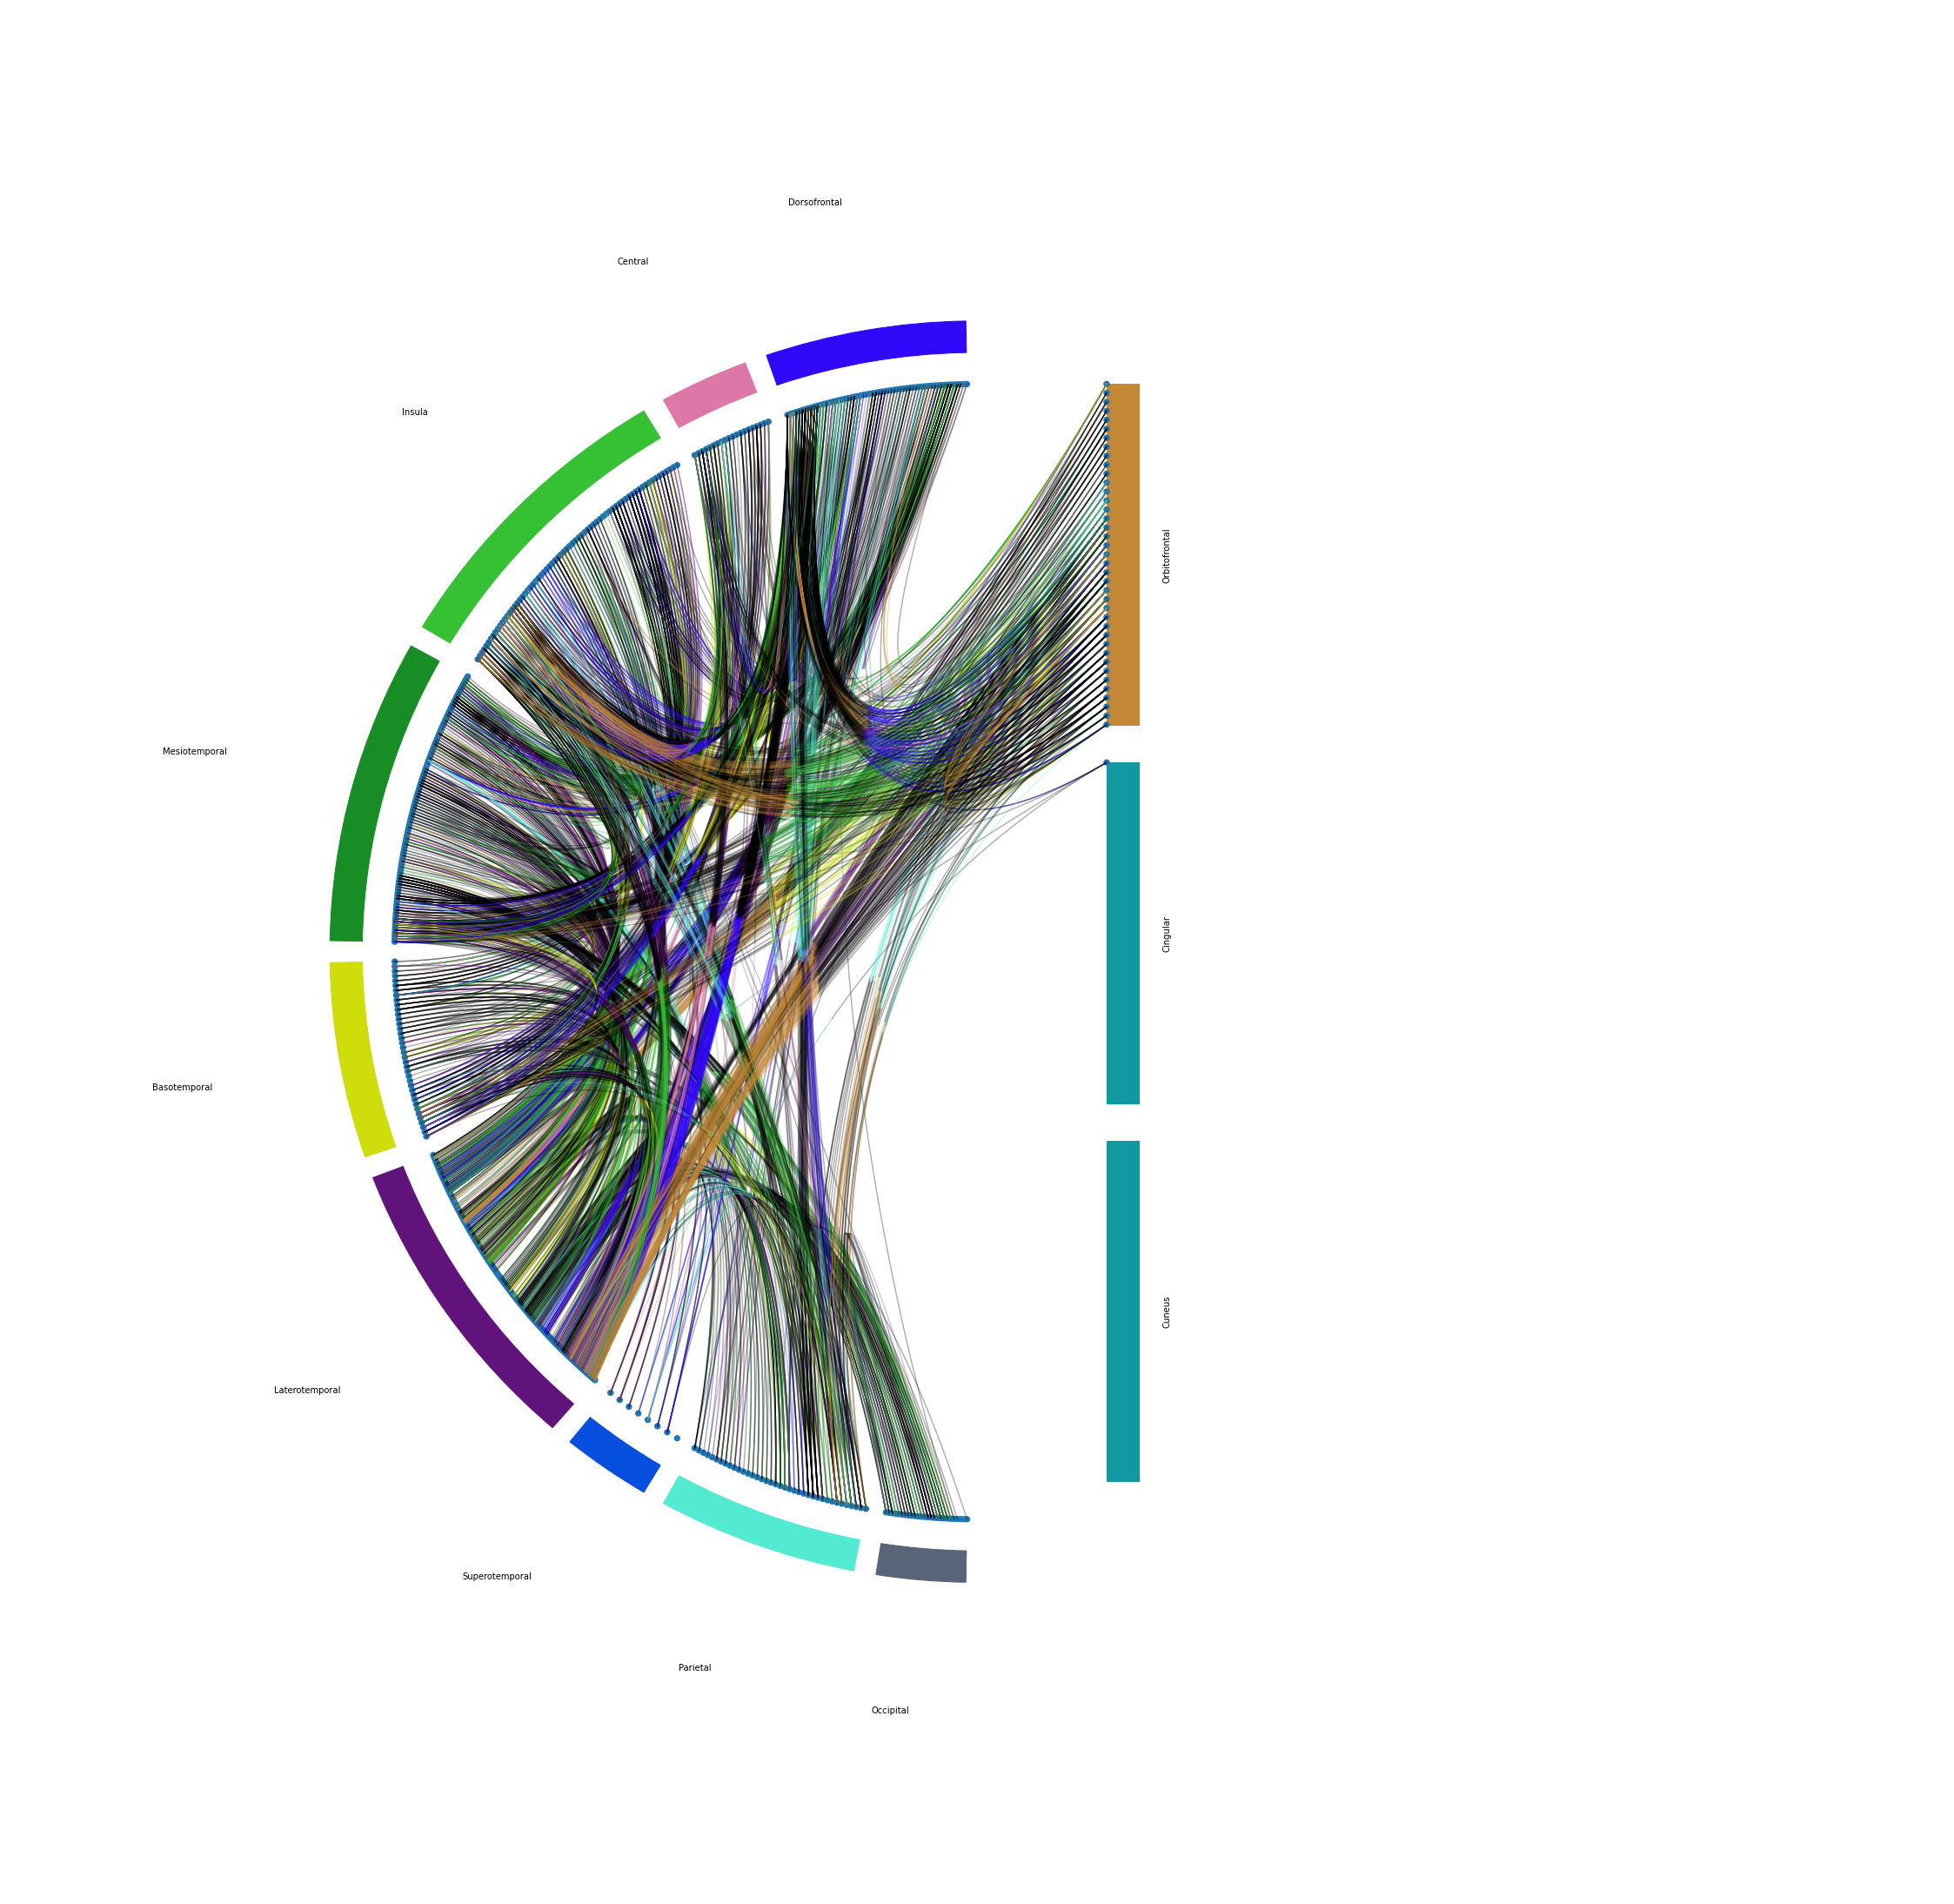

In [73]:
figsize = (40,40)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1, 1, 1)
# despine(ax)
for i in range(n_areas_c):
    t = areas_c[['theta0', 'theta1']].values[i] # both theta
    ring = mpatches.Wedge((0, 0), r_seg, math.degrees(t[1]),math.degrees(t[0]),
                                              width=0.05 * r_seg, color = areas_c.color.values[i])
    ax.add_patch(ring)
    
    d0 = 0
    if (t[0]<0)&(t[1]>0):
        d0 = 2*np.pi
    t = (t[1]+t[0]+d0) / 2
    if t >np.pi: t = t-2*np.pi
    x, y = to_cartesian(r=1.2*r_seg, theta=t)
    ha, va = text_alignment(x, y)
    ax.text(s=areas_c.Area.values[i],
                x=x,
                y=y,
                ha=ha,
                va=va)    
        
for i in range(len(areas_s)): # n_areas_s = len(areas_s)
    rectangle = mpatches.Rectangle((areas_s.x0.values[i],areas_s.y0.values[i]), (-1)**(np.array(plot_hem == 'r'))*0.05 * r_seg, -l_s, color =areas_s.color.values[i])
    ax.add_patch(rectangle)
    x = areas_s.x0.values[i] - 2*0.05 * r_seg*(-1)**(np.array(plot_hem == 'l')*1)
    y= areas_s.y1.values[i]+(areas_s.y0.values[i] -areas_s.y1.values[i])/2
    ha, va = text_alignment(y, y)
    ax.text(s=areas_s.Area.values[i],x=x,y=y,ha='right',va='center', rotation=90)
#plt.plot([-1,0,1],[2,3,3])

####Nodes
go = 1
for i in range(len(data_nodes)):
    # if (-1)**(np.array(plot_hem == 'r')*1)*data_nodes.x.values[i]<0:
    if go:
        node_patch = mpatches.Circle(
                    (data_nodes.x.values[i], data_nodes.y.values[i]), 0.1, lw=1, zorder=2)
        ax.add_patch(node_patch)
####Edges
for i in range(len(data_edges)):  # range(len(data_edges))
    # i = np.random.randint(len(data_edges))
    c0 = data_edges.Stim.values[i]
    c1 = data_edges.Chan.values[i]
    if (len(data_nodes[data_nodes.ID==c1])>0)&(len(data_nodes[data_nodes.ID==c0])>0):
        r1 = data_nodes.loc[data_nodes.ID==c0,'Region'].values[0]
        xy0 = data_nodes.loc[data_nodes.ID==c0,['x','y']].values[0]
        xy1 = data_nodes.loc[data_nodes.ID==c1,['x','y']].values[0]
        verts = [xy0,
            ((-1)**(np.array(plot_hem == 'l')*1)*r_nodes/3, 0),
            xy1,
        ]
        
        # t0 = data_nodes.loc[data_nodes.ID==c0,'theta'].values[0]
        # t1 = data_nodes.loc[data_nodes.ID==c1,'theta'].values[0]
        # verts = [to_cartesian(r_nodes, t0),
        #     ((-1)**(np.array(plot_hem == 'l')*1)*r_nodes/3, 0),
        #     to_cartesian(r_nodes, t1),
        # ]
        
        

        X = np.array(verts)
        n = 100
        tt = np.linspace(0, 1, n)
        xx = P(tt, X)

        plt.plot(xx[:int(n/2),0], xx[:int(n/2),1], color=[0,0,0], alpha=0.3)
        if len(circ_areas.loc[circ_areas.Area==r1,'color'].values)>0:
            col = circ_areas.loc[circ_areas.Area==r1,'color'].values[0]
        else:
            col = 'k'
        plt.plot(xx[int(n/2)-1:,0], xx[int(n/2)-1:,1], color=col, alpha=0.3)
        
plt.xlim([-30,30])
plt.ylim([-30,30])
despine(ax)

plt.show()

###  segments

In [44]:
from scipy.special import comb

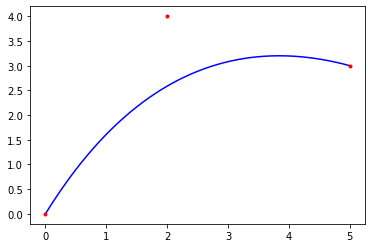

In [51]:
import numpy as np
import matplotlib.pyplot as plt

P0, P1, P2 = np.array([[0, 0],[2, 4],[5, 3]])

# define bezier curve
P = lambda t: (1 - t)**2 * P0 + 2 * t * (1 - t) * P1 + t**2 * P2

# evaluate the curve on [0, 1] sliced in 50 points
points = np.array([P(t) for t in np.linspace(0, 1, 50)])

# get x and y coordinates of points separately
x, y = points[:,0], points[:,1]

# plot
plt.plot(x, y, 'b-')
plt.plot(*P0, 'r.')
plt.plot(*P1, 'r.')
plt.plot(*P2, 'r.')
plt.show()

In [43]:
def B(i, N, t):
    val = comb(N,i) * t**i * (1.-t)**(N-i)
    return val

In [59]:
def B(i, N, t):
        val = comb(N,i) * t**i * (1.-t)**(N-i)
        return val

In [58]:
def P(t, X):
    
    '''
     xx = P(t, X)
     
     Evaluates a Bezier curve for the points in X.
     
     Inputs:
      X is a list (or array) or 2D coords: start , references , end
      t is a number (or list of numbers) in [0,1] where you want to
        evaluate the Bezier curve
      
     Output:
      xx is the set of 2D points along the Bezier curve
    '''
    X = np.array(X)
    N,d = np.shape(X)   # Number of points, Dimension of points
    N = N - 1
    xx = np.zeros((len(t), d))
    
    for i in range(N+1):
        xx += np.outer(B(i, N, t), X[i])
    
    return xx

In [47]:
data_edges = data_con[np.isin(data_con.ChanR,areas_c.Area)&np.isin(data_con.StimR,areas_c.Area)&(data_con.d<20)&(data_con.Dir_index==0)]

In [48]:

# 1. fixed brain areas
circ_areas = pd.read_excel('X:\\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\General_figures\\circ_areas.xlsx')
# areas_c = circ_areas[circ_areas.Plot=='c']
areas_s = circ_areas[circ_areas.Plot=='s']
r_seg = 20
# areas_c = get_info_c(areas_c, r_seg)
areas_s,l_s = get_info_s(areas_s, r_seg)




figsize = (40,40)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1, 1, 1)
# despine(ax)
for i in range(n_areas_c):
    ring = mpatches.Wedge((0, 0), r_seg, math.degrees(areas_c.theta1.values[i]),math.degrees(areas_c.theta0.values[i]),
                                              width=0.05 * r_seg, color = areas_c.color.values[i])
    ax.add_patch(ring)
    x, y = to_cartesian(r=1.2*r_seg, theta=(areas_c.theta0.values[i] + areas_c.theta1.values[i]) / 2)
    ha, va = text_alignment(x, y)
    ax.text(s=areas_c.Area.values[i],
                x=x,
                y=y,
                ha=ha,
                va=va)    
        
for i in range(len(areas_s)): # n_areas_s = len(areas_s)
    rectangle = mpatches.Rectangle((areas_s.x0.values[i],areas_s.y0.values[i]), 0.05 * r_seg, -l_s, color =areas_s.color.values[i])
    ax.add_patch(rectangle)
    x = areas_s.x0.values[i] - 2*0.05 * r_seg
    y= areas_s.y1.values[i]+(areas_s.y0.values[i] -areas_s.y1.values[i])/2
    ha, va = text_alignment(y, y)
    ax.text(s=areas_s.Area.values[i],x=x,y=y,ha='right',va='center', rotation=90)
#plt.plot([-1,0,1],[2,3,3])

####Nodes
for i in range(len(data_nodes)):
    if data_nodes.x.values[i]>0:
        node_patch = mpatches.Circle(
                    (data_nodes.x.values[i], data_nodes.y.values[i]), 0.1, lw=1, zorder=2)
        ax.add_patch(node_patch)
####Edges
for i in range(len(data_edges)):  # range(len(data_edges))
    # i = np.random.randint(len(data_edges))
    c0 = data_edges.Stim.values[i]
    c1 = data_edges.Chan.values[i]
    if (len(data_nodes.loc[data_nodes.ID==c1,'theta'])>0)&(len(data_nodes.loc[data_nodes.ID==c0,'theta'])>0):
        r0 = data_nodes.loc[data_nodes.ID==c1,'Region'].values[0]
        t0 = data_nodes.loc[data_nodes.ID==c0,'theta'].values[0]
        t1 = data_nodes.loc[data_nodes.ID==c1,'theta'].values[0]
        # verts = [to_cartesian(r_nodes, t0),to_cartesian(r_nodes-3, t0),
        #     (r_nodes/3, 0),
        #     to_cartesian(r_nodes, t1),
        # ]
        # codes = [Path.MOVETO,Path.LINETO, Path.CURVE3, Path.CURVE3]
        verts = [to_cartesian(r_nodes, t1),
            (r_nodes/3, 0),
            to_cartesian(r_nodes, t0),
        ]
        #codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
        #path = Path(verts, codes)
        #patch = mpatches.FancyArrowPatch(path=path,
        #                                arrowstyle="-|>,head_length=10,head_width=10", lw=1, edgecolor='k', zorder=1)
        
        #patch = mpatches.PathPatch(path, lw=1, edgecolor='k', zorder=1,**edgeprops)
        #ax.add_patch(patch)
        
        # ## 
        # verts = [to_cartesian(r_nodes, t0),
        #     (r_nodes/3, 0),
        #     to_cartesian(r_nodes, t1)]
        # codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
        # path = Path(verts, codes)
        # #patch = mpatches.FancyArrowPatch(path=path,
        # #                                arrowstyle="-|>,head_length=10,head_width=10", lw=1, edgecolor='k', zorder=1)
        # 
        # patch = mpatches.PathPatch(path, lw=1, edgecolor='b', zorder=1,alpha=0.5, facecolor='none')
        # ax.add_patch(patch)
        
        
        X = np.array(verts)
        n = 100
        tt = np.linspace(0, 1, n)
        xx = P(tt, X)

        plt.plot(xx[:int(n/2),0], xx[:int(n/2),1], color=[0,0,0], alpha=0.3)
        if len(circ_areas.loc[circ_areas.Area==r0,'color'].values)>0:
            col = circ_areas.loc[circ_areas.Area==r0,'color'].values[0]
        else:
            col = 'k'
        plt.plot(xx[int(n/2)-1:,0], xx[int(n/2)-1:,1], color=col, alpha=0.3)

plt.xlim([-30,30])
plt.ylim([-30,30])
despine(ax)

plt.show()

TypeError: <lambda>() takes 1 positional argument but 2 were given

ValueError: Image size of 55077x103414 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2880x2880 with 1 Axes>

In [43]:
data_nodes.loc[data_nodes.ID==c1,'Region'].values[0]

'Laterotemporal'

In [20]:
stop

NameError: name 'stop' is not defined

### Nodes

In [ ]:
len(data_nodes.loc[data_nodes.ID==c0,'theta'])

In [ ]:
data_nodes.loc[data_nodes.ID==c0,'theta']

In [ ]:
data_nodes.loc[data_nodes.ID==c0]

In [ ]:
t0

In [ ]:
to_cartesian(r_node, t0)

In [ ]:
#for region in areas_s.Area:
# region = 'Dorsofrontal'
# n_node = len(data_nodes[data_nodes.Region == region])

## Edges

In [ ]:
data_edges = data_con[np.isin(data_con.ChanR,areas_c.Area)&np.isin(data_con.StimR,areas_c.Area)&(data_con.Dir_index==1)]

In [ ]:
xy = np.zeros((n_node,2))
for i in range(n_node):
    x, y = get_cartesian(r=r_nodes, theta=data_nodes.loc[data_nodes.Region == region, 'theta'].values[i])
    xy[i,0] = x
    xy[i,1] = y
data_nodes.loc[data_nodes.Region == region, 'x'] = xy[:,0]
data_nodes.loc[data_nodes.Region == region, 'y'] = xy[:,1]

In [ ]:
data_nodes

In [ ]:
np.linspace(t[0],t[1],n_node )

In [ ]:
list(G.nodes(data=True))

In [ ]:
start_theta = node_theta(self.nodes_dummies, start)
end_theta = node_theta(self.nodes_dummies, end)
verts = [to_cartesian(r_node, start_theta),
    (r_node/2, 0),
    get_cartesian(r_node, end_theta),
]
color = self.edge_colors[i]  # color for links, edges,
codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
lw = self.edge_widths[i]
path = Path(verts, codes)
# todo: add direction
patch = patches.PathPatch(
    path, lw=lw, edgecolor=color, zorder=1, **self.edgeprops
)
patch = mpatches.FancyArrowPatch(path=path,
                                arrowstyle="-|>,head_length=10,head_width=10", lw=lw, edgecolor='r', zorder=1, **self.edgeprops)
#patch = patches.PathPatch(
#    path, lw=lw, edgecolor=color, zorder=1, **self.edgeprops
#)

self.ax.add_patch(patch)

In [ ]:
import math

In [ ]:
r_plot = 10

In [ ]:
ring = mpatches.Wedge((0, 0), radius, math.degrees(area_borders[i,0]),math.degrees(area_borders[i,1]),
                                              width=0.05 * r_plot)
ax.add_patch(ring)
plt.show()

In [ ]:
math.degrees(-3.17300858)

In [ ]:
x, y = to_cartesian(r=radius, theta=-3.17300858)

In [ ]:
x, y = to_cartesian(r=radius, theta=-2.76460154)

In [ ]:
r = 15
r_node = 2
edge_of_plot = r + r_node
group_label_offset = 3

radius = 1.02 * edge_of_plot + group_label_offset
xs = []
ys = []
has = []
vas = []
n_areas = len(areas_c)


### Plots

In [ ]:
G.label

In [ ]:

c = CircosPlot(
    G,
    node_grouping="region",
    node_subgrouping=["area","subj"],
    node_color="subj",
    node_labels= True,
    node_label= 'label',
    group_label_position="middle",
    group_label_color=True,
    group_label_offset=50,
    figsize=(25,25), 
    fontsize=15
)
c.draw()
plt.show()

In [ ]:
import numpy as np
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import seaborn as sns

#---------------------------------------------
# Drawing two wedge example
#---------------------------------------------
fig, ax = plt.subplots(figsize=(8,8))
plt.title('matplotlib mpatch / path does not accept gradient colors directly')
ring = mpatches.Wedge((0,0), 0.7, 190, 350, color='r',width=0.2, label = 'wedge with only one color, no direction') 
ax.add_patch(ring)

# drawing desired output with easy fix using for-loop, whcih is not working for mpatches.FancyArrowPatch
total_deg = 170
n_steps = 100
d_deg = total_deg / n_steps
colors = sns.color_palette("vlag", n_steps)
for i in range(n_steps-1):
    ring = mpatches.Wedge((0,0), 0.7, i*d_deg, (i+1)*d_deg, color=colors[i],width=0.2) 
    ax.add_patch(ring)
i = i+1
ring = mpatches.Wedge((0,0), 0.7, i*d_deg, (i+1)*d_deg, color=colors[i],width=0.2, label = 'wedge with gradient color using for-loop') 
ax.add_patch(ring)

# drawing desired output with easy fix using for-loop, whcih is not working for mpatches.FancyArrowPatch

verts = [[0.8,0.2],[0,1.4],[-0.9, 0.2]]
codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
lw = 5
path = Path(verts, codes)
patch = mpatches.FancyArrowPatch(path=path,arrowstyle="-|>,head_length=10,head_width=10", lw=lw, color='b', zorder=1, label = 'path that should have gradient color') 
ax.add_patch(patch)

plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.legend()
plt.axis('off')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.transforms
import matplotlib.path
import numpy as np
from matplotlib.collections import LineCollection

def rainbowpath(ax, start, end, cmap="viridis", n=5,lw=3):
    cmap = plt.get_cmap(cmap,n)
    # path
    verts = [[0.8,0.2],[0,1.4],[-0.9, 0.2]]
    codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
    lw = 5
    path = Path(verts, codes)
    patch = mpatches.FancyArrowPatch(path=path,arrowstyle="-|>,head_length=10,head_width=10", lw=lw, color='b', zorder=1, label = 'path that should have gradient color') 
    ax.add_patch(patch)

    # Arrow shaft: LineCollection
    x = np.linspace(start[0],end[0],n)
    y = np.linspace(start[1],end[1],n)
    points = np.array([x,y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, linewidth=lw)
    lc.set_array(np.linspace(0,1,n))
    ax.add_collection(lc)
    
def rainbowpath(ax, start, end, cmap="viridis", n=5,lw=3):
    cmap = plt.get_cmap(cmap,n)
    # Arrow shaft: LineCollection
    x = np.linspace(start[0],end[0],n)
    y = np.linspace(start[1],end[1],n)
    points = np.array([x,y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, linewidth=lw)
    lc.set_array(np.linspace(0,1,n))
    ax.add_collection(lc)

fig,ax = plt.subplots()
ax.axis([0,5,0,4])
ax.set_aspect("equal")

rainbowpath(ax, (3,3), (2,2.5), cmap="viridis", n=100,lw=3)
rainbowpath(ax, (1,1), (1.5,1.5), cmap="jet", n=2,lw=7)
rainbowpath(ax, (4,1.3), (2.7,1.0), cmap="RdYlBu", n=23,lw=5)

plt.show()